In [1]:
import os
import sys
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import Phylo
import pandas as pd
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

In [2]:
def checkSlash(directory):
    if directory[-1] != '/':
        directory = directory + '/'
    return directory

In [3]:
coreDir = '/home/ubuntu/proc/sjspence/170105_PSE/'
snpDir = '11_parsnp_subgroups_snps'
coreDir = checkSlash(coreDir)
snpDir = checkSlash(snpDir)

#Identify subgroup names
subDir = '10_subgroups/'
subgroups = []
for subdirs, dirs, files in os.walk(subDir):
    for d in dirs:
        subgroups.append(d)
subgroups.sort()

**ANCESTRAL RECONSTRUCTION WITH FASTML**

In [47]:
#Removal of branch supports
#Node IDs must not be length 5 and can't be interpreted as floats
def removeBranchSupports(tree):
    treeList = tree.split(')')
    newTree = []
    for i, t in enumerate(treeList):
        t = t.split(':')
        if len(t[0]) == 5 and float(t[0]) > 0.0:
            t = t[1:]
        t = ':'.join(t)
        if (i == 0) or (i == len(treeList)-1):
            newTree.append(t)
        else:
            newTree.append(':' + t)
    newTree = ')'.join(newTree)
    return newTree

#First, edit tree files to remove non-standard quote characters
def editTree(treeFile, treeEdit):
    treeIn = open(treeFile, 'r')
    treeOut = open(treeEdit, 'w')
    for line in treeIn:
        line = line.replace('\'', '')
        line = line.replace('_contigs.fa.ref', '_ref')
        line = line.replace('_contigs.fa', '')
        line = removeBranchSupports(line)
        treeOut.write(line)
    treeIn.close()
    treeOut.close()

#Edit variant file to match tree file leaf IDs
def editVariant(variantFile, variantEdit):
    variantIn = open(variantFile, 'r')
    variantOut = open(variantEdit, 'w')
    for line in variantIn:
        if '>' in line:
            line = line.replace('_contigs.fa.ref', '_ref')
            line = line.replace('_contigs.fa', '')
            variantOut.write(line)
        else:
            variantOut.write(line)
    variantIn.close()
    variantOut.close()

In [49]:
#Edit tree and variant files for ancestral reconstruction
fastmlPath = '/home/ubuntu/tools/FastML.v3.1/www/fastml/FastML_Wrapper.pl'
for s in subgroups:
    s = checkSlash(s)
    treeFile = coreDir + snpDir + s + 'parsnp.tree'
    treeEdit = treeFile.replace('.tree', '_edit.tree')
    editTree(treeFile, treeEdit)
    variantFile = coreDir + snpDir + s + 'variants.mfa'
    variantEdit = variantFile.replace('.mfa', '_edit.mfa')
    editVariant(variantFile, variantEdit)
    outDir = coreDir + snpDir + s + 'fastml/'
    if os.path.exists(outDir):
        os.system('rm -r ' + outDir)
    os.makedirs(outDir)
    os.system('perl ' + fastmlPath + ' --MSA_File ' + variantEdit + ' --seqType nuc --outDir ' + outDir + \
         ' --Tree ' + treeEdit + ' --jointReconstruction no --indelReconstruction ML')

**NOTES**  
subK stalled out, could not finish computing.  
subM also stalled...  
and subN  

All are small groups with suspicious tree structures and long branch lengths (i.e. many snps)

In [4]:
def compareSeqs(seq1, seq2):
    switches = []
    for i, base in enumerate(seq1):
        if seq1[i] != seq2[i]:
            switches.append(i)
    return switches

def recursion(clade, seqDict, switches, homoplasy):
    if clade.is_terminal():
        allHomoplasies[clade.name] = list(set(homoplasy))
    else:
        parentSeq = seqDict[clade.name]
        for c in clade.clades:
            cSeq = seqDict[c.name]
            s = compareSeqs(parentSeq, cSeq)
            for switch in s:
                if switch in switches:
                    homoplasy.append(switch)
                else:
                    switches.append(switch)
            recursion(c, seqDict, switches, homoplasy)

In [5]:
#tree.ancestor.txt
#tree.newick.txt
#seq.marginal.txt
allHomoplasies = {}
for s in subgroups:
    s = checkSlash(s)
    fastmlDir = coreDir + snpDir + s + 'fastml/'
    if not os.path.exists(fastmlDir + 'seq.marginal.txt'):
        continue
    tree = Phylo.read(fastmlDir + 'tree.newick.txt', 'newick')
    records = list(SeqIO.parse(fastmlDir + 'seq.marginal.txt', 'fasta'))
    for r in records:
        r.id = r.id.replace('-', '_')
    seqDict = SeqIO.to_dict(records)
    switches, homoplasy = [], []
    recursion(tree.root, seqDict, switches, homoplasy)

In [6]:
dimorphicHomoplasies = {}
for s in subgroups:
    s = checkSlash(s)
    fastmlDir = coreDir + snpDir + s + 'fastml/'
    if not os.path.exists(fastmlDir + 'seq.marginal.txt'):
        continue
    ##########################
    #GET SET OF SEQ IDS TO CONSIDER FOR THIS SUBGROUP
    print(s)
    records = list(SeqIO.parse(snpDir + s + 'variants_edit.mfa', 'fasta'))
    recordSet = set()
    for r in records:
        r.id = r.id.replace('-', '_')
        recordSet.add(r.id)
    ##########################
    #DETERMINE DIMORPHIC SITES
    variableSites = {}
    for r in records:
        for i, base in enumerate(r.seq):
            if i not in variableSites:
                variableSites[i] = set()
            variableSites[i].add(base)
    recordDict = SeqIO.to_dict(records)
    dimorphic = []
    for site in variableSites:
        if len(variableSites[site]) == 2:
            dimorphic.append(site)
    ##########################
    #KEEP ONLY DIMORPHIC SITES IN HOMOPLASIES
    for seqID in recordSet:
        dimorphicList = []
        for hIndex in allHomoplasies[seqID]:
            if hIndex in dimorphic:
                dimorphicList.append(hIndex)
        dimorphicHomoplasies[seqID] = dimorphicList
    ##########################
    #CHECK WORK
    for seqID in recordSet:
        print(seqID + ': ' + str(len(recordDict[seqID])) + ',' + str(len(allHomoplasies[seqID])) + ',' + \
              str(len(dimorphicHomoplasies[seqID])))

subA/
D17_102043: 748,152,137
D17_102039: 748,321,292
D17_102038: 748,338,307
D17_102037: 748,181,163
D17_102036: 748,289,263
D17_102050_ref: 748,3,3
D17_102049: 748,367,332
D17_102044: 748,7,6
D17_102045: 748,41,36
D17_102046: 748,58,53
D17_102047: 748,85,78
D17_102040: 748,120,110
D17_102041: 748,355,322
D17_102042: 748,240,218
D17_102065: 748,262,238
D17_102048: 748,213,193
D17_102051: 748,307,280
subB/
D17_102237: 1253,341,279
D17_102158: 1253,417,346
D17_102197: 1253,247,200
D17_102194: 1253,357,290
D17_102195: 1253,288,233
D17_102202: 1253,507,430
D17_102061: 1253,220,175
D17_102206: 1253,466,391
D17_102207: 1253,387,317
D17_102208: 1253,536,453
D17_102209: 1253,437,364
D17_102085: 1253,599,507
D17_102086: 1253,568,481
D17_102205_ref: 1253,184,148
D17_102058: 1253,134,104
D17_102052: 1253,264,214
D17_102057: 1253,488,412
D17_102054: 1253,19,14
D17_102211: 1253,444,370
D17_102210: 1253,406,336
D17_102072: 1253,41,31
D17_102141: 1253,0,0
D17_102074: 1253,90,69
D17_102095: 1253,554,

In [7]:
def contigMap(contigs, chrom, pos):
    length = 0
    for i, contig in enumerate(contigs):
        if contig.id != chrom:
            length += len(contig.seq)
        else:
            length += pos
            return length

In [8]:
contigDir = '10_subgroups/'
mappedHomoplasies = {}
for s in subgroups:
    s = checkSlash(s)
    fastmlDir = coreDir + snpDir + s + 'fastml/'
    if not os.path.exists(fastmlDir + 'seq.marginal.txt'):
        continue
    print(s)
    ##########################
    #DESIGN REFERENCE CHROMOSOME ARRAY FOR PLOTTING
    records = list(SeqIO.parse(snpDir + s + 'variants_edit.mfa', 'fasta'))
    reference = ''
    for r in records:
        if '_ref' in r.id:
            reference = r.id.replace('_ref', '')
    print(reference)
    referenceFile = contigDir + s + reference + '_contigs.fa'
    refContigs = list(SeqIO.parse(referenceFile, 'fasta'))
    ##########################
    #GET SET OF SEQ IDS TO CONSIDER FOR THIS SUBGROUP
    recordSet = set()
    for r in records:
        r.id = r.id.replace('-', '_')
        recordSet.add(r.id)
    ##########################
    #INPUT VARIANT CHROMOSOME POSITIONS
    vcfFile = open(snpDir + s + 'variants.vcf', 'r')
    variantDict = {}
    ct = 0
    for line in vcfFile:
        if line[0] == '#':
            continue
        line = line.strip().split('\t')
        variantDict[ct] = [line[0], line[1]] #pos: [chrom, chrom pos]
        ct += 1    
    ##########################
    #TRANSLATE CHROMOSOME POSITIONS
    for r in records:
        variantList = dimorphicHomoplasies[r.id]
        mappedList = []
        for vID in variantList:
            chrom = variantDict[vID][0]
            pos = variantDict[vID][1]
            mappedPos = contigMap(refContigs, chrom, int(pos))
            mappedList.append(mappedPos)
        mappedHomoplasies[r.id] = mappedList

subA/
D17-102050
subB/
D17-102205
subC/
D17-102235
subD/
D17-102006
subG/
D17-102028
subH/
D17-102089
subI/
D17-102218
subJ/
D17-102240
subL/
D17-102083
subO/
D17-102010


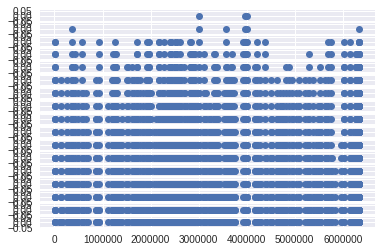

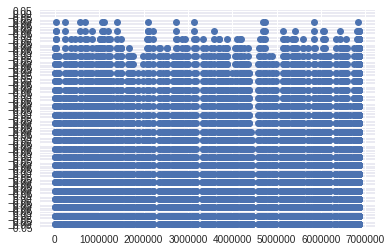

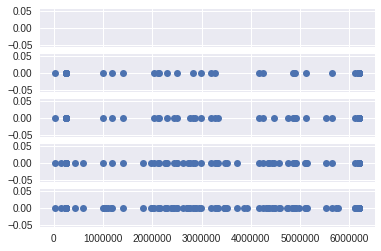

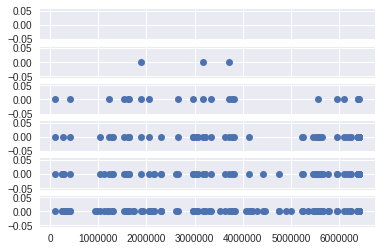

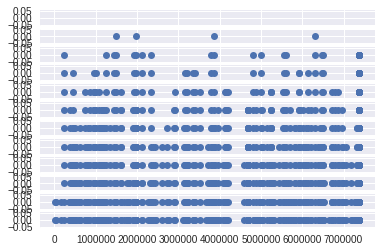

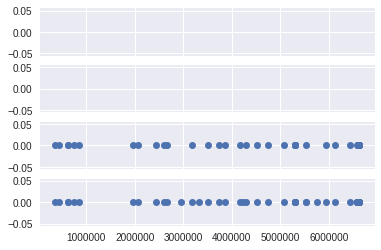

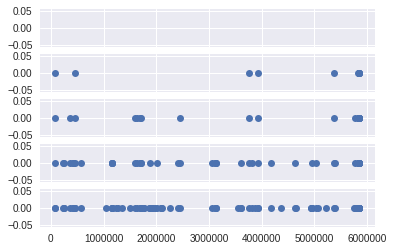

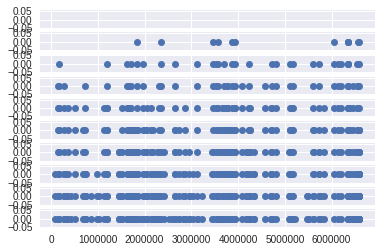

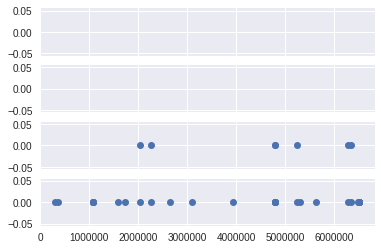

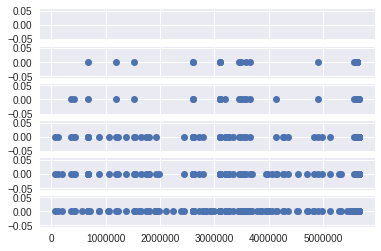

In [9]:
for s in subgroups:
    s = checkSlash(s)
    fastmlDir = coreDir + snpDir + s + 'fastml/'
    if not os.path.exists(fastmlDir + 'seq.marginal.txt'):
        continue
    tree = Phylo.read(fastmlDir + 'tree.newick.txt', 'newick')
    terminals = []
    for leaf in tree.get_terminals():
        terminals.append(leaf.name)
    f, axarr = plt.subplots(len(tree.get_terminals()), sharex = True)
    for i, leaf in enumerate(terminals):
        axarr[i].plot(mappedHomoplasies[leaf], [0]*len(mappedHomoplasies[leaf]), "o")

In [13]:
#Export homoplasies for visualization in R
homoplasyDir = '12_homoplasies/'
if not os.path.exists(homoplasyDir):
    os.makedirs(homoplasyDir)
for s in subgroups:
    s = checkSlash(s)
    outFile = open(homoplasyDir + s.replace('/', '_homoplasies.txt'), 'w')
    fastmlDir = coreDir + snpDir + s + 'fastml/'
    if not os.path.exists(fastmlDir + 'seq.marginal.txt'):
        continue
    tree = Phylo.read(fastmlDir + 'tree.newick.txt', 'newick')
    terminals = []
    for leaf in tree.get_terminals():
        terminals.append(leaf.name)
    for i, leaf in enumerate(terminals):
        outFile.write(leaf + ',' + ','.join(map(str, mappedHomoplasies[leaf])) + '\n')
    outFile.close()

In [38]:
numTrees = 0
for s in subgroups:
    s = checkSlash(s)
    fastmlDir = coreDir + snpDir + s + 'fastml/'
    if not os.path.exists(fastmlDir + 'seq.marginal.txt'):
        continue
    numTrees += 1
gs = gridspec.GridSpec(numTrees, 2)

for i, s in enumerate(subgroups):
    s = checkSlash(s)
    fastmlDir = coreDir + snpDir + s + 'fastml/'
    if not os.path.exists(fastmlDir + 'seq.marginal.txt'):
        continue
    tree = Phylo.read(fastmlDir + 'tree.newick.txt', 'newick')
    terminals = []
    for leaf in tree.get_terminals():
        terminals.append(leaf.name)
    ax1 = plt.subplots(gs[i, 0])
    ax2 = plt.subplots(gs[i, 1])
    
    #f, axarr = plt.subplots(len(tree.get_terminals()), sharex = True, gs[1,1])
    #for i, leaf in enumerate(terminals):
    #    axarr[i].plot(mappedHomoplasies[leaf], [0]*len(mappedHomoplasies[leaf]), "o")


TypeError: unsupported operand type(s) for *: 'SubplotSpec' and 'int'

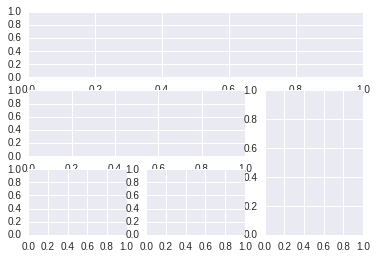

In [35]:
########################################################
####START HERE
########################################################
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1,:-1])
ax3 = plt.subplot(gs[1:, -1])
ax4 = plt.subplot(gs[-1,0])
ax5 = plt.subplot(gs[-1,-2])

In [23]:
#[method for method in dir(testTree) if callable(getattr(testTree, method))]
#globals(testTree)
#for clade in testTree.find_clades():
#    print clade.name
#[method for method in dir(testTree.root) if callable(getattr(testTree.root, method))]
#compareSNPs(testTree.root)